In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, RationalQuadratic
import itertools as it
from itertools import combinations

from sklearn.preprocessing import StandardScaler
import torch

## Load the Data

In [48]:
# File paths
input_file_path = "/Users/macponcho/a_IMPERIAL_COLLEGE/CAPSTONE Project - Black Box optimization/initial_data/function_3/initial_inputs.npy"
output_file_path = "/Users/macponcho/a_IMPERIAL_COLLEGE/CAPSTONE Project - Black Box optimization/initial_data/function_3/initial_outputs.npy"

# Load the data
inputs = np.load(input_file_path)
outputs = np.load(output_file_path)

# Convert to pandas DataFrame for easier manipulation and analysis
df = pd.DataFrame(inputs, columns=[f'Input_{i+1}' for i in range(inputs.shape[1])])
df['Output'] = outputs

df

,Input_1,Input_2,Input_3,Output
0,0.171525,0.343917,0.248737,-0.112122
1,0.242114,0.644074,0.272433,-0.087963
2,0.534906,0.398501,0.173389,-0.111415
3,0.492581,0.611593,0.340176,-0.034835
4,0.134622,0.219917,0.458206,-0.048008
5,0.345523,0.941360,0.269363,-0.110621
6,0.151837,0.439991,0.990882,-0.398926
7,0.645503,0.397143,0.919771,-0.113869
8,0.746912,0.284196,0.226300,-0.131461
9,0.170477,0.697032,0.149169,-0.094190


In [49]:
#Adicion de datos conforme el concurso ha avanzado

#Datos pre-competencia que aparecieron
new_data_0=pd.DataFrame([{'Input_1':0.111111,'Input_2':0.111111,'Input_3':0.111111,'Output':-0.1090975}]) 
df=pd.concat([df,new_data_0],ignore_index=True)

# 5 may
new_data=[0.85,0.05,0.681579,-0.19787908330143]
df.loc[len(df)] = new_data

new_data=[0.52,0.95,0.95,-0.241773816684692]
df.loc[len(df)] = new_data

# 14 may
df.loc[len(df)]=[0.9,0.9,0.1,-0.0720975299563213]
df.loc[len(df)]=[0.01,0.5,0.732105,-0.116062658733115]
df.loc[len(df)]=[0.9,0.9,0.9,-0.0926333729946998]

# 17 may
df.loc[len(df)]=[0.01,0.99,0.99,-0.423896123258828]

# 17 may
df.loc[len(df)]=[0.98,0.98,0.02,-0.0977387765667451]
df.loc[len(df)]=[0.473684,0.68421,0.210527,-0.130718048654499]
# *** Adicional from compañero
#df.loc[len(df)]=[0.436884,0.453066,0.442615,-0.004062]
#df.loc[len(df)]=[0.742412,0.625096,0.423735,-0.0036179926]

# 2 jun
df.loc[len(df)]=[0.473684,0.473684,0.473684,-0.0335630947301124]

# 12 jun
df.loc[len(df)]=[1.00000e-06,2.92930e-01,4.74748e-01,-0.018309383]
df.loc[len(df)]=[0.717171,0.575757,0.575757,-0.031395603]

# 18 jun
df.loc[len(df)]=[1.00000e-06,3.13132e-01,4.74748e-01,-0.0236744997317792]
df.loc[len(df)]=[0.999999,0.545454,0.797979,-0.0681719956481182]

#Print
df

,Input_1,Input_2,Input_3,Output
0,0.171525,0.343917,0.248737,-0.112122
1,0.242114,0.644074,0.272433,-0.087963
2,0.534906,0.398501,0.173389,-0.111415
3,0.492581,0.611593,0.340176,-0.034835
4,0.134622,0.219917,0.458206,-0.048008
5,0.345523,0.941360,0.269363,-0.110621
6,0.151837,0.439991,0.990882,-0.398926
7,0.645503,0.397143,0.919771,-0.113869
8,0.746912,0.284196,0.226300,-0.131461
9,0.170477,0.697032,0.149169,-0.094190


## Function 3: Drug Discovery Problem
#### In this example, you are doing drug discovery! You can select three compounds to create a drug, and receive a measurement of the people’s adverse reaction to the drug. You want to make this as close as possible to zero. (hint: one of the variables may not cause any effects on the person).

## Data exploration

df=df.drop(index=6)
df=df.drop(index=21)
df=df.drop(index=16)
df=df.drop(index=17)
df

In [4]:
#df['Output']=abs(np.log(abs(df['Output'])))
#df

In [5]:
# Display basic statistics
print("Basic Statistical Summary:")
print(df.describe())

# Check for any missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())

Basic Statistical Summary:
         Input_1    Input_2    Input_3     Output
count  29.000000  29.000000  29.000000  29.000000
mean    0.451073   0.552808   0.466691  -0.112570
std     0.338961   0.277135   0.307714   0.096716
min     0.000001   0.050000   0.020000  -0.423896
25%     0.151837   0.313132   0.226300  -0.116063
50%     0.473684   0.545454   0.458206  -0.097739
75%     0.717171   0.725136   0.732105  -0.048008
max     0.999999   0.990000   0.990882  -0.018309

Missing values in the dataset:
Input_1    0
Input_2    0
Input_3    0
Output     0
dtype: int64


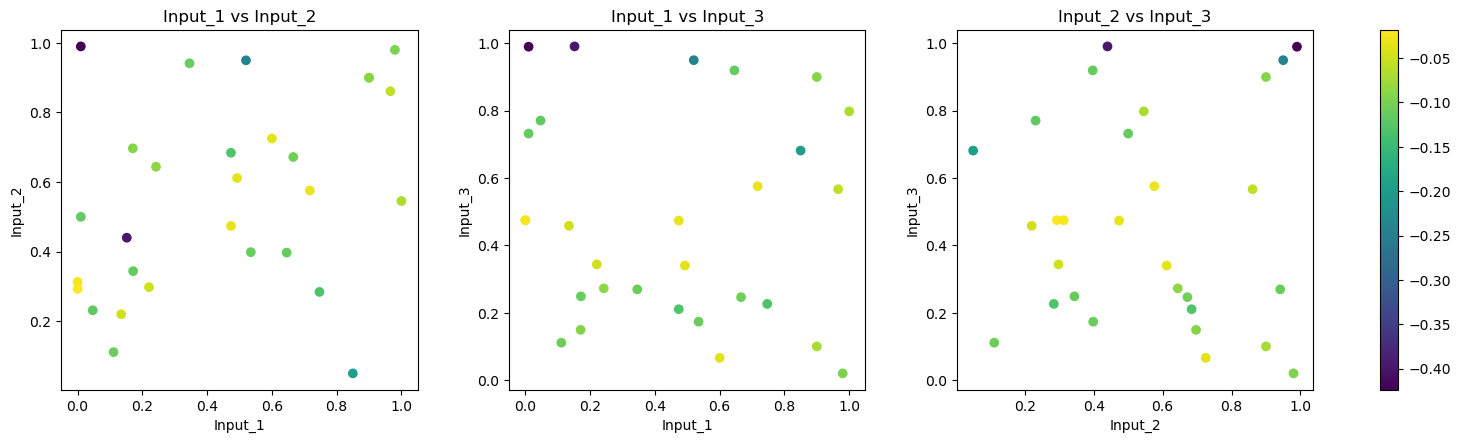

In [6]:
from itertools import combinations

# Calculate all pair combinations of input columns
input_columns = df.columns[df.columns.str.startswith('Input')]  # Select only columns that start with 'Input'
pair_combinations = list(combinations(input_columns, 2))  # Get all combinations of Input columns taken 2 at a time

# Determine the grid size for subplots
num_plots = len(pair_combinations)
num_cols = 3  # Set number of columns in the subplot grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate rows needed, round up

# Create a figure with subplots in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))  # Adjust figure size as needed
fig.tight_layout(pad=4.0)  # Add spacing between plots

# Flatten axes array for easier iteration if it's 2D
axes = axes.flatten()

# Plotting each combination in the grid
for i, (x_col, y_col) in enumerate(pair_combinations):
    ax = axes[i]
    scatter = ax.scatter(df[x_col], df[y_col], c=df['Output'], cmap='viridis')
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f'{x_col} vs {y_col}')

# Add a colorbar to the last plot
fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=.02)

# Turn off axes for any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()

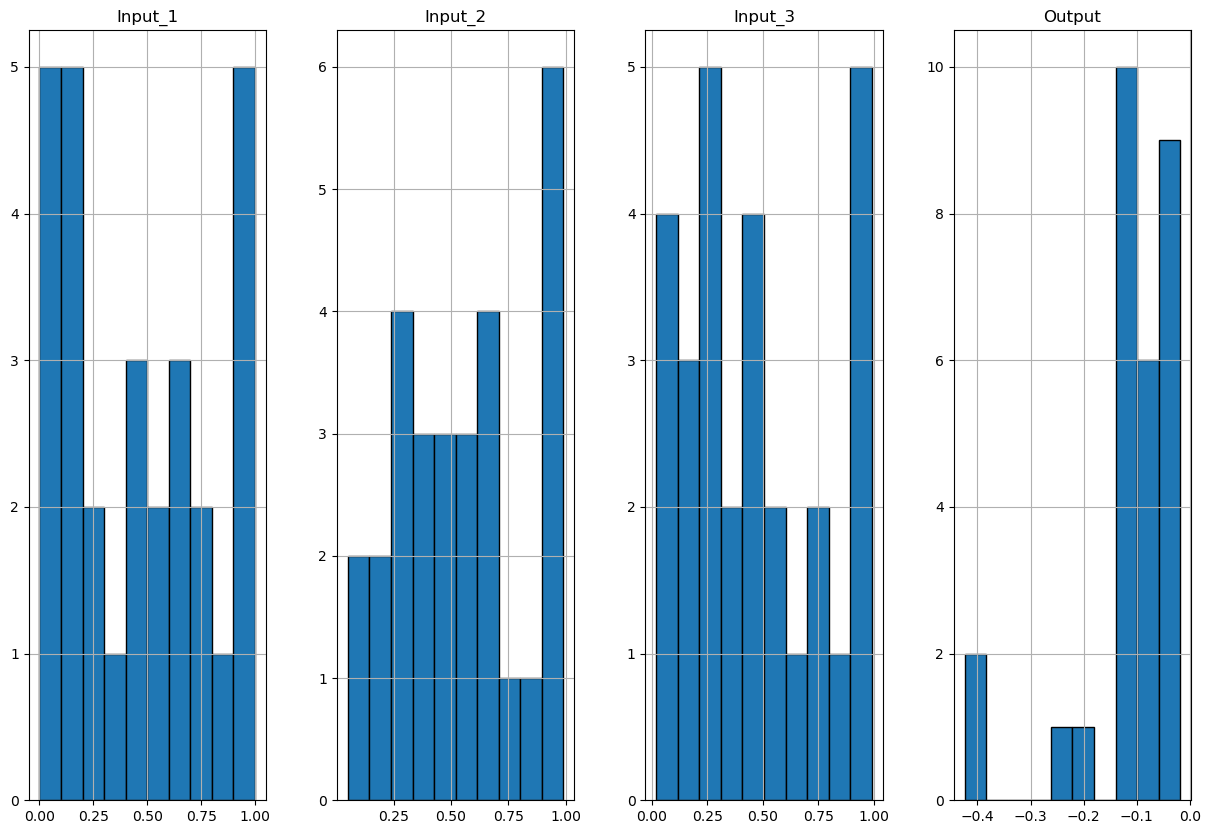

In [7]:
# Plot histograms for each column to understand distributions
df.hist(bins=10, figsize=(15, 10), layout=(-1, 4), edgecolor='black')
plt.subplots_adjust(hspace=0.5)
plt.show()

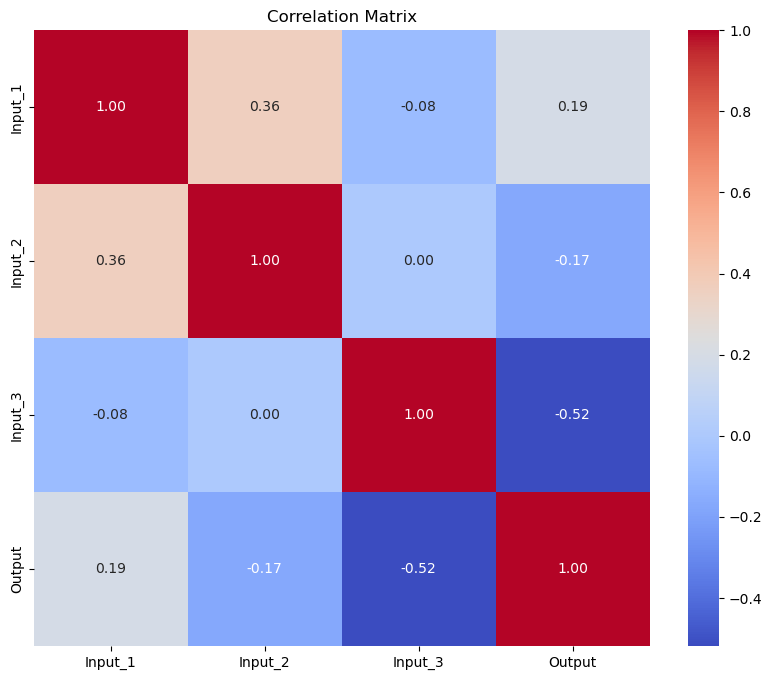

In [8]:
# Compute the correlation matrix
corr = df.corr()

# Generate a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()

/Users/macponcho/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


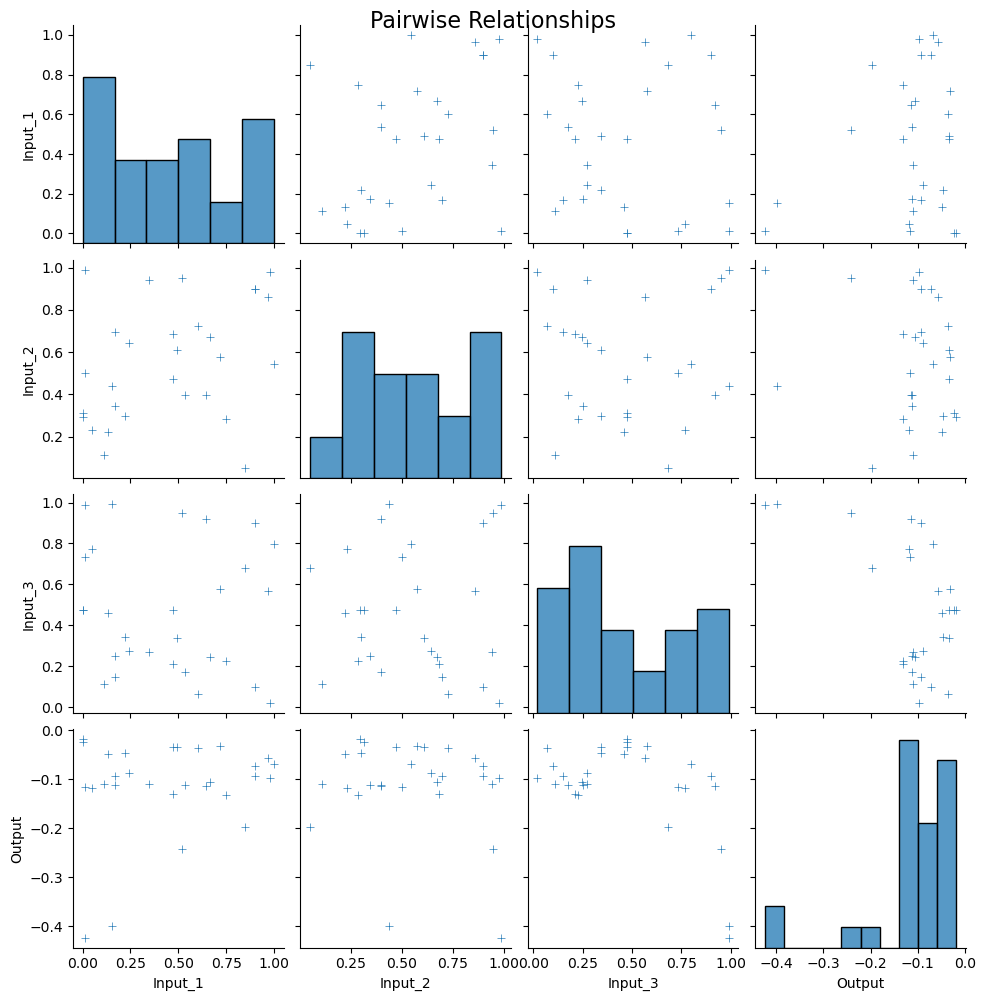

In [9]:
# Use pairplot to visualize the relationships between variables
sns.pairplot(df, kind='scatter', diag_kind='hist', markers='+')
plt.suptitle('Pairwise Relationships', verticalalignment='baseline', fontsize=16)
plt.show()

## FOR THIS CASE ONLY


In [189]:
# Jugar sin el index porque es un valor negativo muy grande, entender que pasa quitando ese valor
#df=df.drop(index=6)
#df=df.drop(index=21)
#df

## Definir las variables

In [11]:
X = df.drop(columns=['Output'])
y = df[['Output']] 

#yy=abs(np.log(abs(y)))
#y=yy
#yy

# Estandarizamos datos
scaler = StandardScaler()
y = torch.tensor(scaler.fit_transform(y)).float()

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, RationalQuadratic
import itertools as it

# Parameters of the model
#****************************************
noise_assumption = 1e-6 # noise assumption, a hyper-parameter (default 1e-10)

rbf_lengthscale = .3 # lengthscale parameter (default = 1), comenzaremos con 0.2 y luego ir descendiendo a 0.1 o menos
   #ARD. Automatic relevance determination
    
# define kernel of GP
kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')

# Define a kernel with both smooth and rough components, and noise handling
#kernel = Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=0.1) + RationalQuadratic(length_scale=1.0, alpha=0.1)
#kernel=kernel + WhiteKernel(noise_level=1e-5) #ESPECIAL PARA FUNCION 1 POR LAS ANOMALIAS
#kernel = Matern(length_scale=[0.1, 0.1, 0.1], nu=1.5, length_scale_bounds=(0.01, 1), ARD=True)

#Grid:
GG=100    #Numero de datos para cada variable en el Grid.  
dim=3     #Numero de Inputs
#******************************************************

x1 = np.linspace(0.000001, .999999, GG)     #Genera la primer variable. RANGO DE EXPLORACION
X_grid = np.fromiter(it.chain(*it.product(x1, repeat=dim)), dtype=float).reshape(-1,dim) #Genera todas las variables
# Convert X_grid into a DataFrame with meaningful names
X_grid_df = pd.DataFrame(X_grid, columns=X.columns)

# Fit the Gaussian process - Surrogate model
GPR_model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)
GPR_model.fit(X, y)

#Genera la funcion del Surrogate model para cada punto del grid
mean, std = GPR_model.predict(X_grid_df, return_std = True)

In [29]:
#Acquisition function
#######################################################

beta = 1.96
acquisition_function = mean + beta * std

#######################################################

idx_max = np.argmax(acquisition_function) #en que index esta el maximo del acquisitonm function
next_query = X_grid[idx_max] #que valores tienes los inputs en este maximo estimado

# Formatting the single row
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print(f"[{formatted_row}]")

[0.000001-0.979797-0.000001]


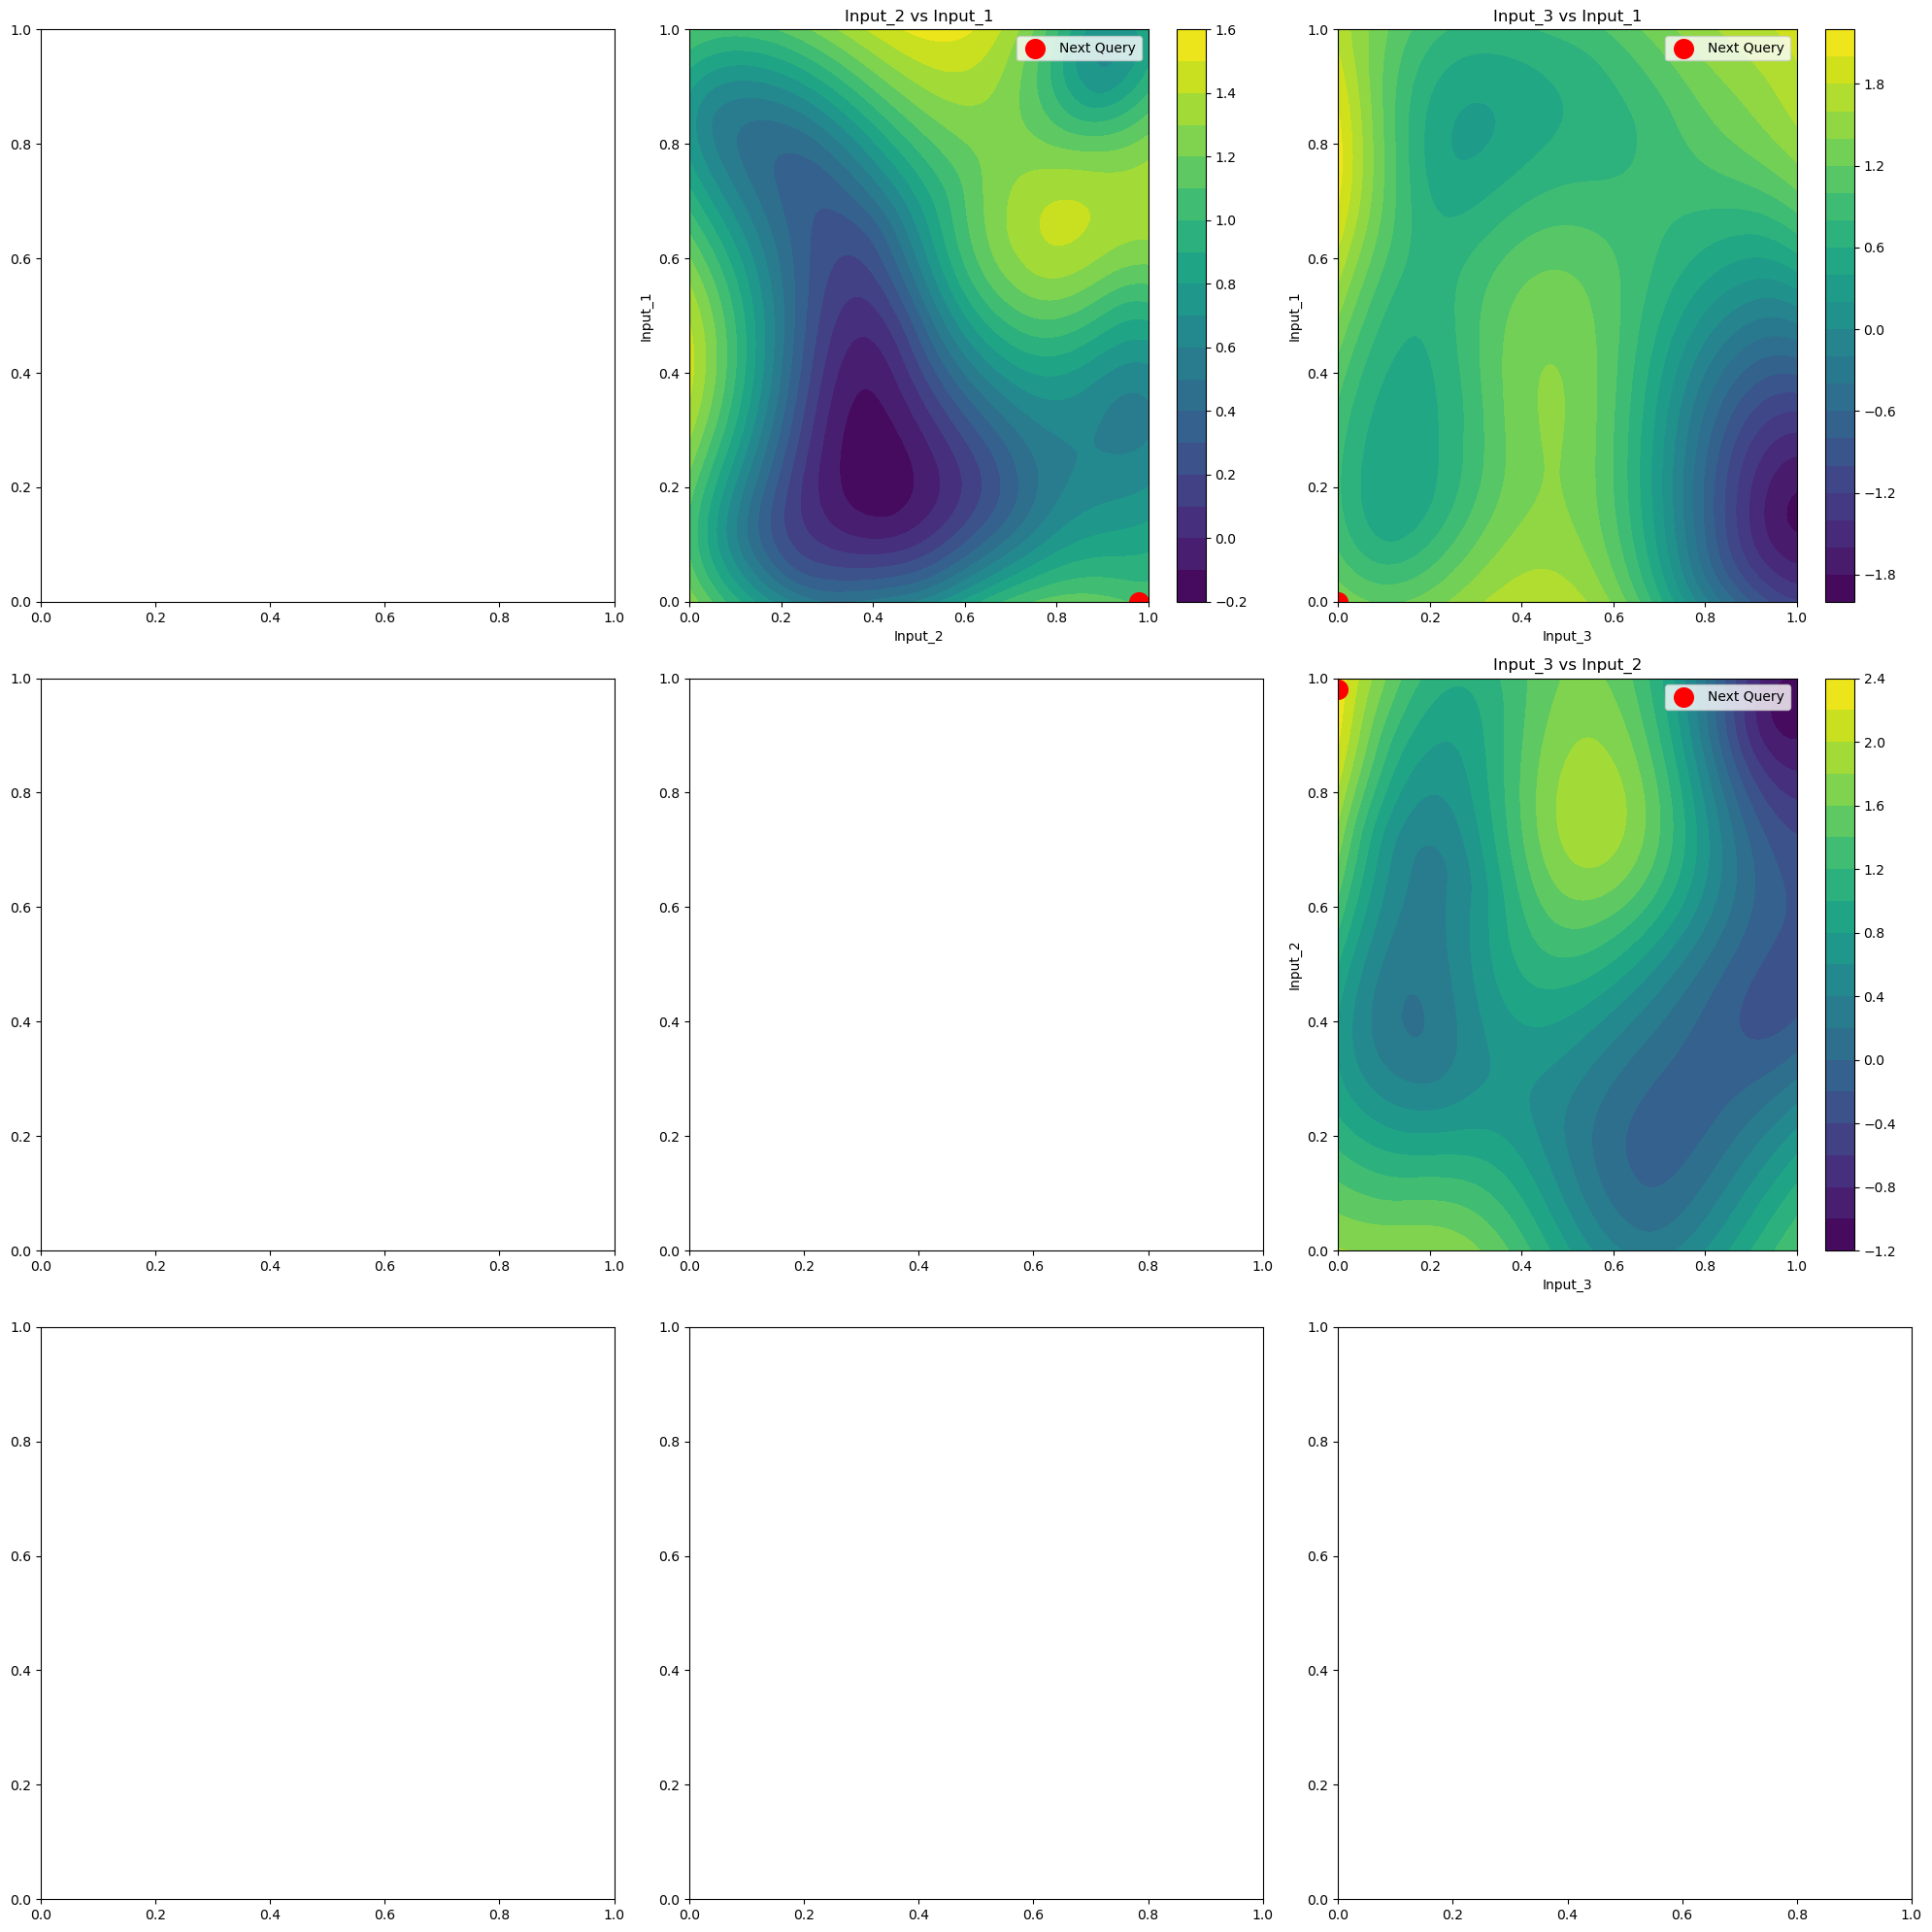

In [30]:
input_labels = X.columns.tolist()  # Correctly fetching input labels from DataFrame

# Create figure for plotting
fig, axes = plt.subplots(dim, dim, figsize=(20, 20))

for i, j in combinations(range(dim), 2):
    ax = axes[i, j] if dim > 1 else axes[max(i, j)]  # Correct indexing for subplot
    reshaped_acq_func = acquisition_function.reshape([GG]*dim)

    # Reduce all dimensions except for i and j
    axes_to_avg = tuple(k for k in range(dim) if k not in [i, j])
    reshaped_acq_func = np.mean(reshaped_acq_func, axis=axes_to_avg)
    
    # Create meshgrid for the contour plot
    x, y = np.meshgrid(np.linspace(0, 1, GG), np.linspace(0, 1, GG))
    cp = ax.contourf(x, y, reshaped_acq_func, cmap='viridis', levels=20)
    fig.colorbar(cp, ax=ax)
    
    # Plot the location of the next query: Ensure axis alignment is correct
    # Swap the indices for x and y based on their respective dimensions
    next_query_x = next_query[j]  # Using j for x-axis
    next_query_y = next_query[i]  # Using i for y-axis

    # Convert to plot scale
    next_query_x_idx = int(next_query_x * (GG - 1))
    next_query_y_idx = int(next_query_y * (GG - 1))

    # Plot the location of the next query
    ax.scatter(next_query_x, next_query_y, color='red', s=200, label='Next Query')
    ax.legend()

    ax.set_title(f'{input_labels[j]} vs {input_labels[i]}')  # Ensure correct title
    ax.set_xlabel(input_labels[j])  # x-axis should use j
    ax.set_ylabel(input_labels[i])  # y-axis should use i

plt.tight_layout()
plt.show()


In [31]:
#Acquisition function variando parametros

#######################################################
beta = 1.96
acquisition_function = mean + beta * std
idx_max = np.argmax(acquisition_function) #en que index esta el maximo del acquisitonm function
next_query = X_grid[idx_max] #que valores tienes los inputs en este maximo estimado
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print("Beta 1.96",f"[{formatted_row}]")
#######################################################
beta = 0.00000001
acquisition_function = mean + beta * std
idx_max = np.argmax(acquisition_function) #en que index esta el maximo del acquisitonm function
next_query = X_grid[idx_max] #que valores tienes los inputs en este maximo estimado
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print("Beta casi CERO",f"[{formatted_row}]")
#######################################################
beta = 2.6
acquisition_function = mean + beta * std
idx_max = np.argmax(acquisition_function) #en que index esta el maximo del acquisitonm function
next_query = X_grid[idx_max] #que valores tienes los inputs en este maximo estimado
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print("Beta 2.6",f"[{formatted_row}]")
#######################################################
acquisition_function = std
idx_max = np.argmax(acquisition_function) #en que index esta el maximo del acquisitonm function
next_query = X_grid[idx_max] #que valores tienes los inputs en este maximo estimado
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print("ONLY std",f"[{formatted_row}]")
#######################################################

Beta 1.96 [0.000001-0.979797-0.000001]
Beta casi CERO [0.717171-0.808080-0.000001]
Beta 2.6 [0.000001-0.999999-0.000001]
ONLY std [0.999999-0.000001-0.000001]


# 28 Apr. Ask 1. [0.520000-0.950000-0.950000]

- Explorando los extremos

#### 4 May
Vamos a volver a submit el primero y voy a submit uno mas.
Pr si las dudas, voy a subir el original como segundo submit.
- [0.850000-0.050000-0.681579]
- [0.520000-0.950000-0.950000]

#### 10 may
Nos falta info a l mitad de Input 2 y nos faltan mas datos de Input 3 altos
Input 3 tiene alta correlacion. Los otros 2 hasta ahora no
Cuanto quito el mas negativo (drop index 6, el Input 1 muestra mas correlacion, el Input 2 parece irrelevante
Parece que input 1 y 3 en niveles bajos es bueno
- Beta 2.6 [0.900000-0.900000-0.100000]
- ONLY std [0.010000-0.500000-0.732105]
- Beta 2.6 [0.900000-0.900000-0.900000]

#### 14 May
- Beta casi CERO [0.371053-0.319474-0.474211]
- Beta 2.6 [0.010000-0.990000-0.680526] lengths .15
- [0.010000-0.990000-0.990000] length .3 (o lenght .15 sin el index 5)
- **** vamos por [0.010000-0.990000-0.990000] ---- pareciera que es exploratorio (Y fecvtivamente fue muy negativo)

#### 17 may
- Len .3, noise 1e-4
- Beta 1.96 [0.999999-0.000001-0.000001], Beta casi CERO [0.421053-0.421053-0.526316]
- len .2,
- Beta 1.96 [0.999999-0.000001-0.000001] Beta casi CERO [0.368421-0.421053-0.473684]
- len 0.1
- Beta 1.96 [0.421053-0.000001-0.999999], Beta casi CERO [0.368421-0.263158-0.421053]
- Log optim
- Beta 1.96 [0.999999-0.999999-0.000001], query EI: [0.000001-0.999999-0.999999], query PI: [0.052632-0.894736-0.999999]
- Aplique transformacion LOG al inicio y me da [0.473684-0.684210-0.210527]
****** Me voy por [0.980000-0.980000-0.020000] y [0.473684-0.684210-0.210527]

#### 1 Junio

**SIN AGREGAR DATOS COMPAÑERO
- Beta 1.96 [0.999999-0.000001-0.000001]
- Beta casi CERO [0.473684-0.578947-0.473684]

- CON DATOS compañero
- Beta 1.96 [0.999999-0.000001-0.000001]
- Beta casi CERO [0.578947-0.631579-0.526316]

- ESTANDARIZADO DATOS + LOG LIKELIHOOD
- Beta 1.96 [0.526316-0.526316-0.526316], Beta casi CERO [0.473684-0.473684-0.473684]
- Beta 1.96 [0.578947-0.578947-0.473684], Beta casi CERO [0.473684-0.526316-0.421053 (SIN LOG LIKELIHOOD)

- **** Voy por [0.473684-0.473684-0.473684]

#### 7 juni
- Log LIKE
Beta 1.96 [0.999999-0.545454-0.727272]
Beta casi CERO [0.717171-0.575757-0.575757] +
Beta 2.6 [0.999999-0.525252-0.757575]
query EI: [0.090910-0.838383-0.999999]
query PI: [0.050506-0.949494-0.999999]
max [0.742412,0.625096,0.423735

- +++++ ELIMINANDO DATOS COMPAÑERO [0.000001-0.292930-0.474748] ++

- VAMOS POR [0.000001-0.292930-0.474748] y [0.717171-0.575757-0.575757]

#### 12 jun

- log like normal
Beta 1.96 [0.999999-0.545454-0.797979] +
Beta casi CERO [0.707070-0.575757-0.565656]
Beta 2.6 [0.999999-0.505050-0.999999]

- log like sin datos compañero
Beta 1.96 [0.999999-0.515151-0.999999]
Beta casi CERO [0.000001-0.313132-0.474748] ++
Beta 2.6 [0.999999-0.505050-0.999999]

- *** Vamos por [0.000001-0.313132-0.474748]++ y [0.999999-0.545454-0.797979]+

#### 18 jun

Maximo compañero
+++df.loc[len(df)]=[0.436884,0.453066,0.442615,-0.004062]
+++df.loc[len(df)]=[0.742412,0.625096,0.423735,-0.0036179926]
Maximo ex-compañero
+++df.loc[len(df)]=[0.000001,0,292930,0.474748,-0.018309383]

- New model

- Con datos compañero
Next query point UCB with Beta 1.96: [0.000000-1.000000-0.000000]
Next query point UCB with Beta 0.01: [0.676768-0.545455-0.555556]
Next query point UCB with Beta 1.0: [0.686869-0.545455-0.565657]
Next query point EI: [0.050505-0.828283-1.000000]
Next query point PI: [0.050505-0.959596-1.000000]

- Sin datos compañero
Next query point UCB with Beta 1.96: [0.000000-0.000000-0.505051]
Next query point UCB with Beta 0.01: [0.000000-0.333333-0.484848]
Next query point UCB with Beta 1.0: [0.000000-0.383838-0.474747]
Next query point EI: [0.050505-0.828283-1.000000]
Next query point PI: [0.050505-0.959596-1.000000]

## Probando optimizacion de parametros LOG LIKELIHOOD

In [13]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
import itertools as it
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.acquisition import gaussian_lcb, gaussian_ei, gaussian_pi
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress specific warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

X = df.drop(columns=['Output'])
y = df[['Output']] 


# Estandarizamos datos
scaler = StandardScaler()
y = torch.tensor(scaler.fit_transform(y)).float()


# Define the search space for Bayesian Optimization
space = [
    Real(1e-3, 1e-0, name='length_scale'),
    Real(1e-10, 1e-2, name='noise_level')
]

# Evaluation function (Log-Likelihood)
def evaluate_model(length_scale, noise_level):
    # Define kernel with given length scale
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=noise_level)
    GPR_model = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)
    GPR_model.fit(X, y)
    log_likelihood = GPR_model.log_marginal_likelihood()
    return -log_likelihood

# Use the search space in the objective function
@use_named_args(space)
def objective(**params):
    return evaluate_model(**params)

# Perform Bayesian Optimization
res = gp_minimize(objective, space, n_calls=50, n_initial_points=10, random_state=33)

# Get the best parameters
best_length_scale = res.x[0]
best_noise_level = res.x[1]

print(f"Best length scale: {best_length_scale}")
print(f"Best noise level: {best_noise_level}")


Best length scale: 0.4238673650837359
Best noise level: 1e-10


In [14]:
# Define the best kernel
best_kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=best_length_scale, length_scale_bounds='fixed') + WhiteKernel(noise_level=best_noise_level)

# Fit the Gaussian Process with the best parameters
GPR_model_best = GaussianProcessRegressor(kernel=best_kernel, alpha=best_noise_level)
GPR_model_best.fit(X, y)

# Predictions using the surrogate model
mean, std = GPR_model_best.predict(X_grid_df, return_std=True)

# Acquisition function
beta = 1.96
acquisition_function = mean + beta * std

# Find the next query point
idx_max = np.argmax(acquisition_function)
next_query = X_grid[idx_max]

# Formatting the single row
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print(f"Next query point with Beta 1.96: [{formatted_row}]")
print("     ")


Next query point with Beta 1.96: [0.000001-0.000001-0.505050]
     


In [17]:
#Acquisition function variando parametros

#######################################################
beta = 1.96
acquisition_function = mean + beta * std
idx_max = np.argmax(acquisition_function) #en que index esta el maximo del acquisitonm function
next_query = X_grid[idx_max] #que valores tienes los inputs en este maximo estimado
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print("Beta 1.96",f"[{formatted_row}]")
#######################################################
beta = .00001
acquisition_function = mean + beta * std
idx_max = np.argmax(acquisition_function) #en que index esta el maximo del acquisitonm function
next_query = X_grid[idx_max] #que valores tienes los inputs en este maximo estimado
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print("Beta casi CERO",f"[{formatted_row}]")
#######################################################
beta = 2.6
acquisition_function = mean + beta * std
idx_max = np.argmax(acquisition_function) #en que index esta el maximo del acquisitonm function
next_query = X_grid[idx_max] #que valores tienes los inputs en este maximo estimado
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print("Beta 2.6",f"[{formatted_row}]")
#######################################################
acquisition_function = std
idx_max = np.argmax(acquisition_function) #en que index esta el maximo del acquisitonm function
next_query = X_grid[idx_max] #que valores tienes los inputs en este maximo estimado
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print("ONLY std",f"[{formatted_row}]")
#######################################################

# Acquisition function choices

acquisition_function = gaussian_ei(X_grid, model=GPR_model_best, xi=0.01)

# Find the next query point
idx_max = np.argmax(acquisition_function)
next_query = X_grid[idx_max]

# Formatting the single row
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print(f"query EI: [{formatted_row}]")

# */*******************************************************************************

acquisition_function = gaussian_pi(X_grid, model=GPR_model_best, xi=0.01)

# Find the next query point
idx_max = np.argmax(acquisition_function)
next_query = X_grid[idx_max]

# Formatting the single row
formatted_row = '-'.join(format(x, ".6f") for x in next_query)
print(f"query PI: [{formatted_row}]")

Beta 1.96 [0.000001-0.000001-0.505050]
Beta casi CERO [0.000001-0.313132-0.484849]
Beta 2.6 [0.000001-0.999999-0.000001]
ONLY std [0.999999-0.000001-0.000001]
query EI: [0.080809-0.838383-0.999999]
query PI: [0.050506-0.949494-0.999999]


# New model

In [50]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.acquisition import gaussian_lcb, gaussian_ei, gaussian_pi
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import warnings
from sklearn.exceptions import ConvergenceWarning
from itertools import combinations

# Suppress specific warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Assuming df is already loaded with data

X = df.drop(columns=['Output'])
y = df[['Output']]

# Standardize inputs and outputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Define the search space for Bayesian Optimization
space = [
    Real(1e-3, 1e-1, name='length_scale'),
    Real(1e-12, 1e-2, name='noise_level')
]

# Evaluation function (Log-Likelihood)
def evaluate_model(length_scale, noise_level):
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
    GPR_model = GaussianProcessRegressor(kernel=kernel, alpha=noise_level)
    GPR_model.fit(X_scaled, y_scaled)
    log_likelihood = GPR_model.log_marginal_likelihood()
    return -log_likelihood

# Use the search space in the objective function
@use_named_args(space)
def objective(**params):
    return evaluate_model(**params)

# Perform Bayesian Optimization
res = gp_minimize(objective, space, n_calls=50, n_initial_points=10, random_state=32)

# Get the best parameters
best_length_scale = res.x[0]
best_noise_level = res.x[1]

print(f"Best length scale: {best_length_scale}")
print(f"Best noise level: {best_noise_level}")

# Define the best kernel
best_kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=best_length_scale) + WhiteKernel(noise_level=best_noise_level)

# Fit the Gaussian Process with the best parameters
GPR_model_best = GaussianProcessRegressor(kernel=best_kernel, alpha=best_noise_level)
GPR_model_best.fit(X_scaled, y_scaled)

# Flexible grid setup for predictions
def generate_grid(ranges, num_points):
    grid_axes = [np.linspace(start, end, num_points) for start, end in ranges]
    grid = np.array(list(it.product(*grid_axes)))
    return grid

#****
# Define custom ranges for each input
# Modify these ranges as needed
input_ranges = [
    (0.000001, 0.999999),  # Range for Input_1
    (0.000001, 0.999999),  # Range for Input_2
    (0.000001, 0.999999)   # Range for Input_3
    # Add more ranges for additional inputs if necessary
]

# Ensure the number of ranges matches the number of inputs
if len(input_ranges) != X.shape[1]:
    raise ValueError("The number of input ranges must match the number of inputs.")

#****   
    
GG = 100  # Number of data points for each variable in the grid
X_grid = generate_grid(input_ranges, GG)

# Convert to DataFrame with appropriate column names
X_grid_df = pd.DataFrame(X_grid, columns=X.columns)
# Scale the grid points
X_grid_scaled = scaler_X.transform(X_grid_df)

# Predictions using the surrogate model
mean_scaled, std_scaled = GPR_model_best.predict(X_grid_scaled, return_std=True)
mean_scaled = mean_scaled.reshape(-1, 1)  # Reshape to 2D array
mean = scaler_y.inverse_transform(mean_scaled).flatten()  # Inverse transform to original scale and flatten to 1D array
std = std_scaled * scaler_y.scale_[0]  # Scale standard deviation appropriately

# Acquisition function: UCB
beta = 1.96
acquisition_function_ucb = mean + beta * std

# Find the next query point (UCB)
idx_max_ucb = np.argmax(acquisition_function_ucb)
next_query_ucb = X_grid[idx_max_ucb]
formatted_row_ucb = '-'.join(format(x, ".6f") for x in next_query_ucb)
print(f"Next query point UCB with Beta {beta}: [{formatted_row_ucb}]")

# Calculate and collect query points
query_points = [
    (next_query_ucb, 'UCB Beta 1.96', 'red', 'o')
]

# Test different beta values for UCB and other acquisition functions
for beta, color, marker in zip([0.01, 1.00, 2.6], ['blue', 'green', 'purple'], ['x', 's', 'd']):
    acquisition_function = mean + beta * std
    idx_max = np.argmax(acquisition_function)
    next_query = X_grid[idx_max]
    query_points.append((next_query, f'UCB Beta {beta}', color, marker))
    formatted_row = '-'.join(format(x, ".6f") for x in next_query)
    print(f"Next query point UCB with Beta {beta}: [{formatted_row}]")

# Use other acquisition functions
acquisition_function_ei = gaussian_ei(X_grid_scaled, model=GPR_model_best, xi=0.01)
idx_max_ei = np.argmax(acquisition_function_ei)
next_query_ei = X_grid[idx_max_ei]
query_points.append((next_query_ei, 'EI', 'orange', 'v'))
formatted_row_ei = '-'.join(format(x, ".6f") for x in next_query_ei)
print(f"Next query point EI: [{formatted_row_ei}]")

acquisition_function_pi = gaussian_pi(X_grid_scaled, model=GPR_model_best, xi=0.01)
idx_max_pi = np.argmax(acquisition_function_pi)
next_query_pi = X_grid[idx_max_pi]
query_points.append((next_query_pi, 'PI', 'cyan', '^'))
formatted_row_pi = '-'.join(format(x, ".6f") for x in next_query_pi)
print(f"Next query point PI: [{formatted_row_pi}]")


Best length scale: 0.1
Best noise level: 0.009175584815942777
Next query point UCB with Beta 1.96: [0.000001-0.000001-0.505050]
Next query point UCB with Beta 0.01: [0.000001-0.333334-0.484849]
Next query point UCB with Beta 1.0: [0.000001-0.383839-0.474748]
Next query point UCB with Beta 2.6: [0.000001-0.999999-0.000001]
Next query point EI: [0.050506-0.828282-0.999999]
Next query point PI: [0.050506-0.959595-0.999999]


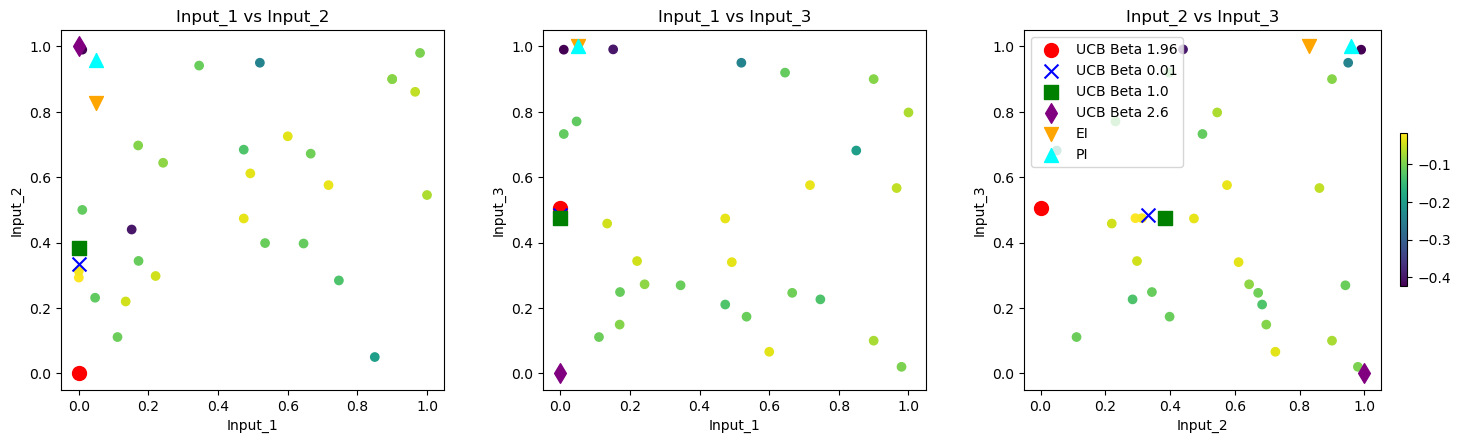

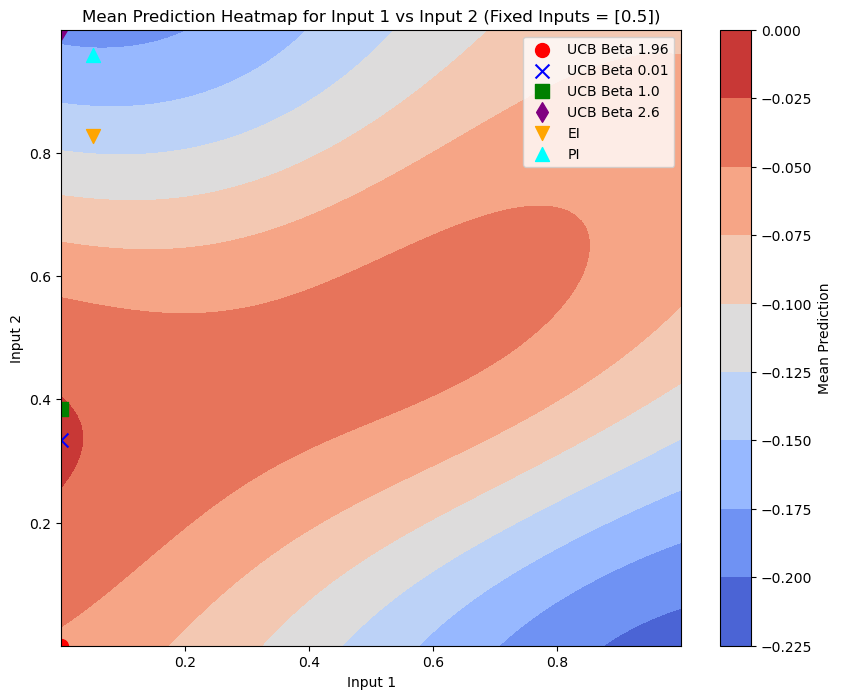

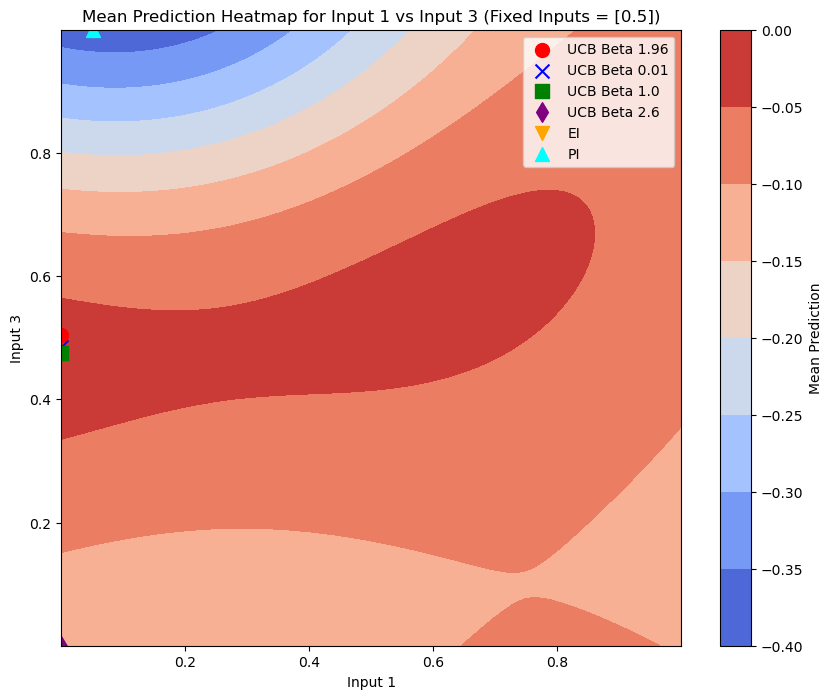

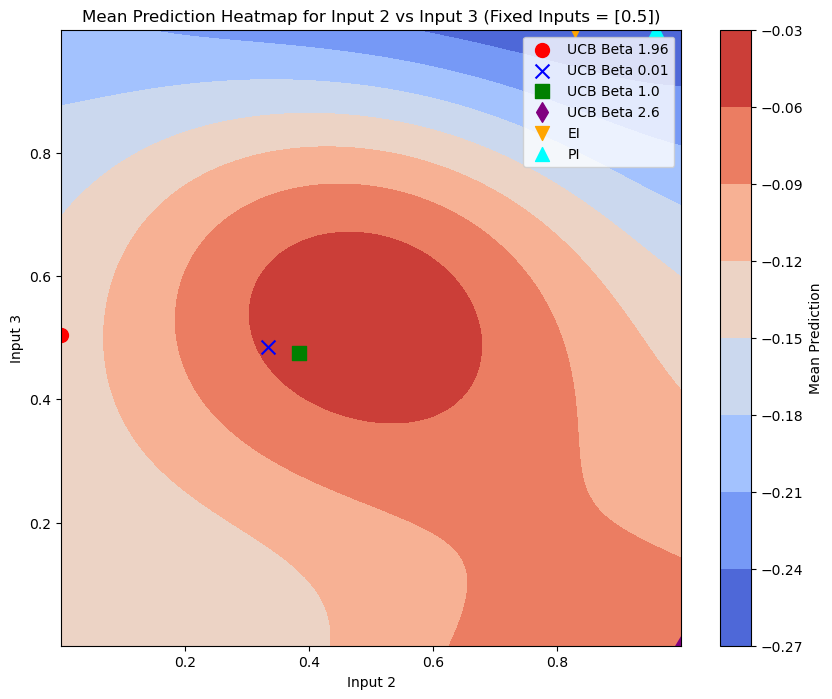

In [51]:
# Visualization function to include pairwise scatter plots and heatmaps
def visualize_data(X_original, y_original, X_grid, query_points, input_ranges):
    num_inputs = X_original.shape[1]
    
    # Pairwise scatter plots with color gradient and query points
    if num_inputs > 1:
        input_columns = X_original.columns
        pair_combinations = list(combinations(input_columns, 2))
        num_plots = len(pair_combinations)
        num_cols = 3
        num_rows = (num_plots + num_cols - 1) // num_cols

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))
        fig.tight_layout(pad=4.0)
        axes = axes.flatten()

        for i, (x_col, y_col) in enumerate(pair_combinations):
            ax = axes[i]
            scatter = ax.scatter(X_original[x_col], X_original[y_col], c=y_original.values.flatten(), cmap='viridis')
            ax.set_xlabel(x_col)
            ax.set_ylabel(y_col)
            ax.set_title(f'{x_col} vs {y_col}')
            
            for query, label, color, marker in query_points:
                ax.scatter(query[input_columns.get_loc(x_col)], query[input_columns.get_loc(y_col)], color=color, marker=marker, s=100, label=label)
            
            if i == num_plots - 1:
                fig.colorbar(scatter, ax=ax, orientation='vertical', fraction=.02)
        
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.legend()
        plt.show()

    # Generate heatmaps for all pairs of inputs
    for (i, j) in combinations(range(num_inputs), 2):
        fixed_input_values = [0.5] * (num_inputs - 2)
        fixed_indices = [k for k in range(num_inputs) if k != i and k != j]

        X_grid_fixed = generate_grid(input_ranges[:2], GG)
        X_grid_fixed_full = np.zeros((X_grid_fixed.shape[0], num_inputs))
        X_grid_fixed_full[:, [i, j]] = X_grid_fixed
        for idx, fixed_val in zip(fixed_indices, fixed_input_values):
            X_grid_fixed_full[:, idx] = fixed_val

        X_grid_fixed_full_df = pd.DataFrame(X_grid_fixed_full, columns=X_original.columns)
        X_grid_fixed_scaled = scaler_X.transform(X_grid_fixed_full_df)
        mean_fixed_scaled, std_fixed_scaled = GPR_model_best.predict(X_grid_fixed_scaled, return_std=True)
        mean_fixed = scaler_y.inverse_transform(mean_fixed_scaled.reshape(-1, 1)).flatten()

        plt.figure(figsize=(10, 8))
        plt.contourf(X_grid_fixed[:, 0].reshape(GG, GG), X_grid_fixed[:, 1].reshape(GG, GG), mean_fixed.reshape(GG, GG), cmap='coolwarm')
        plt.colorbar(label='Mean Prediction')
        
        for query, label, color, marker in query_points:
            plt.scatter(query[i], query[j], color=color, marker=marker, s=100, label=label)

        plt.title(f'Mean Prediction Heatmap for Input {i+1} vs Input {j+1} (Fixed Inputs = {fixed_input_values})')
        plt.xlabel(f'Input {i+1}')
        plt.ylabel(f'Input {j+1}')
        plt.legend()
        plt.show()

# Call the visualization function using the original data
visualize_data(X, y, X_grid, query_points, input_ranges)